# Solving Inverse Problem with Pretrained Latent Variable Models
Lukas Mosser 2022

In [1]:
!nvidia-smi

Sun Aug 14 12:37:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installing Libraries

In [2]:
!pip install torch-ema
!git clone https://github.com/matteo-ronchetti/torch-radon.git
%cd torch-radon
!python setup.py install
!pip install -e .
%cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'torch-radon'...
remote: Enumerating objects: 1750, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 1750 (delta 112), reused 125 (delta 100), pack-reused 1591
Receiving objects: 100% (1750/1750), 16.43 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (1048/1048), done.
/content/torch-radon
Using CUDA_HOME=/usr/local/cuda
Compiling src/forward.template
/usr/local/cuda/bin/nvcc -std=c++11 -ccbin=g++ -Xcompiler -fPIC -Xcompiler -static -Xcompiler -static-libgcc -Xcompiler -static-libstdc++ -I./include -gencode arch=compute_60,code=sm_60 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -DNDEBUG -O3 --generate-line-info --compiler-options -Wall -c src/forward.cu -o objs/cuda/forward.o
Compiling src/noise.cu
/usr/local/cu

## Restart Runtime after installing packackes

Go to "Runtime -> Restart Runtime" to restart and run from the next cell called "Importing Libraries" to continue the notebook.

## Importing Libraries

In [2]:
from __future__ import print_function
import argparse
import os
import random
import matplotlib.animation as animation
from IPython.display import HTML
import imageio
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Resize
from tqdm import tqdm
from torch_radon import Radon, RadonFanbeam
from torch_ema import ExponentialMovingAverage

# Set random seed for reproducibility
manualSeed = 69
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

Random Seed:  69


# Training the Generative Adversarial Network (GAN)

## Setting the GAN hyperparameters

In [3]:
# Number of workers for dataloader
workers = 6

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Downloading the Image and Creating Training and Test Datasets

### Scenario 1: River Channel System

In [4]:
!wget https://raw.githubusercontent.com/elaloy/gan_for_gradient_based_inv/master/training/ti/ti.png

--2022-08-14 12:37:17--  https://raw.githubusercontent.com/elaloy/gan_for_gradient_based_inv/master/training/ti/ti.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144022 (141K) [image/png]
Saving to: ‘ti.png’

ti.png              100%[===================>] 140.65K  --.-KB/s    in 0.02s   

2022-08-14 12:37:17 (8.74 MB/s) - ‘ti.png’ saved [144022/144022]



### Define a function to extract patches from the training image

In [5]:
def extract_patches(img, patch_size=(128, 64), stride=16, flip_up_down=False, flip_left_right=False, mirror=False):
  patches = []
  for i in range(0, img.shape[0]-patch_size[0], stride):
    for j in range(0, img.shape[1]-patch_size[1], stride):
      patches.append(img[i:i+patch_size[0], j:j+patch_size[1]])
  patches = np.array(patches)
  all_patches = [patches]
  if flip_up_down:
    all_patches.append(patches[..., ::-1, :])
  if flip_left_right:
    all_patches.append(patches[..., :, ::-1])
  if mirror:
    all_patches.append(patches[..., ::-1, ::-1])
  patches = np.concatenate(all_patches, axis=0)
  return patches

### Loading the Image and creating the DataLoaders

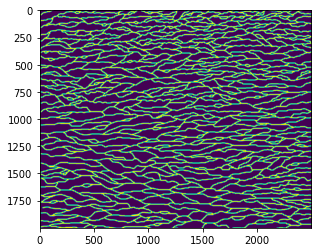

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
ti = imageio.imread('ti.png')

patch_size = (64, 64)
stride = 16

train_ti = ti[:ti.shape[0]-500]

test_ti = ti[-500:]

plt.imshow(train_ti)
plt.show()

plt.imshow(test_ti)
plt.show()

train_patches = extract_patches(train_ti, patch_size=patch_size, stride=stride, flip_up_down=True, mirror=True, flip_left_right=True)
test_patches = extract_patches(test_ti, patch_size=patch_size, stride=stride)

train_patches = torch.from_numpy(train_patches).unsqueeze(1)
test_patches = torch.from_numpy(test_patches).unsqueeze(1)

train_dataset = TensorDataset(train_patches/255., torch.zeros(train_patches.size(0), 1))
test_dataset = TensorDataset(test_patches/255., torch.zeros(test_patches.size(0), 1))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Scenario 2: Loading the MNIST dataset 

In [7]:
train_dataset = MNIST(root=".", transform=Compose([ToTensor(), Resize(image_size)]), download=True, train=True)
test_dataset = MNIST(root=".", transform=Compose([ToTensor(), Resize(image_size)]), download=True, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Plot a Training Batch

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


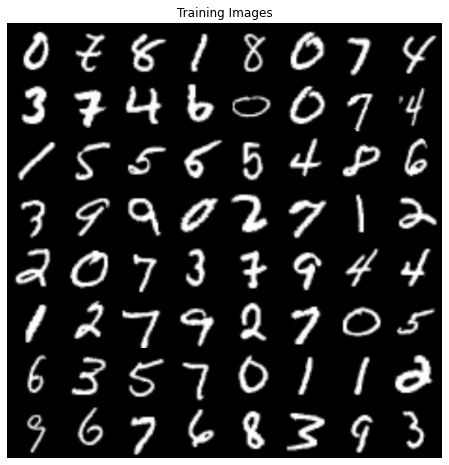

In [8]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Plot a Test Batch

In [9]:
# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Network and weight initialization definitions

### Defining the weight initialization scheme

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Defining the Generator Network Architecture

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### Defining the Discriminator Network Architecture

In [12]:
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=True)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=True)),
            # nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=True)),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=True)),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            spectral_norm(nn.Conv2d(ndf * 8, ndf, 4, 1, 0, bias=True)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            spectral_norm(nn.Linear(ndf, 1)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Defining the loss criteria, initialize the models, and optimizers

### Define the loss criteria

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


### Initialize the Generator and Discriminator Model

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

ema = ExponentialMovingAverage(netG.parameters(), decay=0.999)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )

### Initialize the Optimizer

In [15]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training the GAN model on the training dataset

In [16]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu)
        # Calculate loss on all-real batch
        errD_real = criterion(output.view(-1), label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output.view(-1), label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output.view(-1), label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        ema.update()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
          with ema.average_parameters():
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0/20][0/469]	Loss_D: 1.3806	Loss_G: 0.6928	D(x): 0.5179	D(G(z)): 0.5145 / 0.5002
[0/20][50/469]	Loss_D: 0.1168	Loss_G: 4.9687	D(x): 0.9482	D(G(z)): 0.0353 / 0.0312
[0/20][100/469]	Loss_D: 0.0912	Loss_G: 4.0671	D(x): 0.9539	D(G(z)): 0.0392 / 0.0449
[0/20][150/469]	Loss_D: 0.0824	Loss_G: 3.2172	D(x): 0.9562	D(G(z)): 0.0351 / 0.0411
[0/20][200/469]	Loss_D: 0.1555	Loss_G: 2.7739	D(x): 0.9351	D(G(z)): 0.0796 / 0.0631
[0/20][250/469]	Loss_D: 0.3255	Loss_G: 1.8471	D(x): 0.8876	D(G(z)): 0.1685 / 0.1578
[0/20][300/469]	Loss_D: 0.2307	Loss_G: 2.2397	D(x): 0.8847	D(G(z)): 0.0786 / 0.1083
[0/20][350/469]	Loss_D: 0.2318	Loss_G: 2.4585	D(x): 0.8949	D(G(z)): 0.0897 / 0.0866
[0/20][400/469]	Loss_D: 0.3518	Loss_G: 2.7328	D(x): 0.8667	D(G(z)): 0.1574 / 0.0653
[0/20][450/469]	Loss_D: 0.7339	Loss_G: 2.0187	D(x): 0.7330	D(G(z)): 0.3080 / 0.1354
[1/20][0/469]	Loss_D: 0.2267	Loss_G: 2.9196	D(x): 0.9247	D(G(z)): 0.1244 / 0.0547
[1/20][50/469]	Loss_D: 0.2572	Loss_G: 2.7451	D(x): 0.9161	D(G(z)): 0.1400 / 0.065

## Reviewing the trained GAN model

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

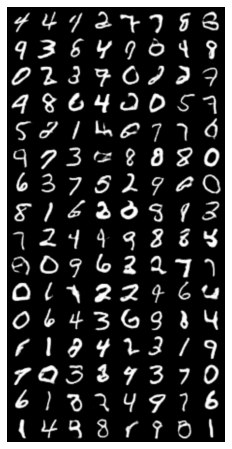

In [18]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


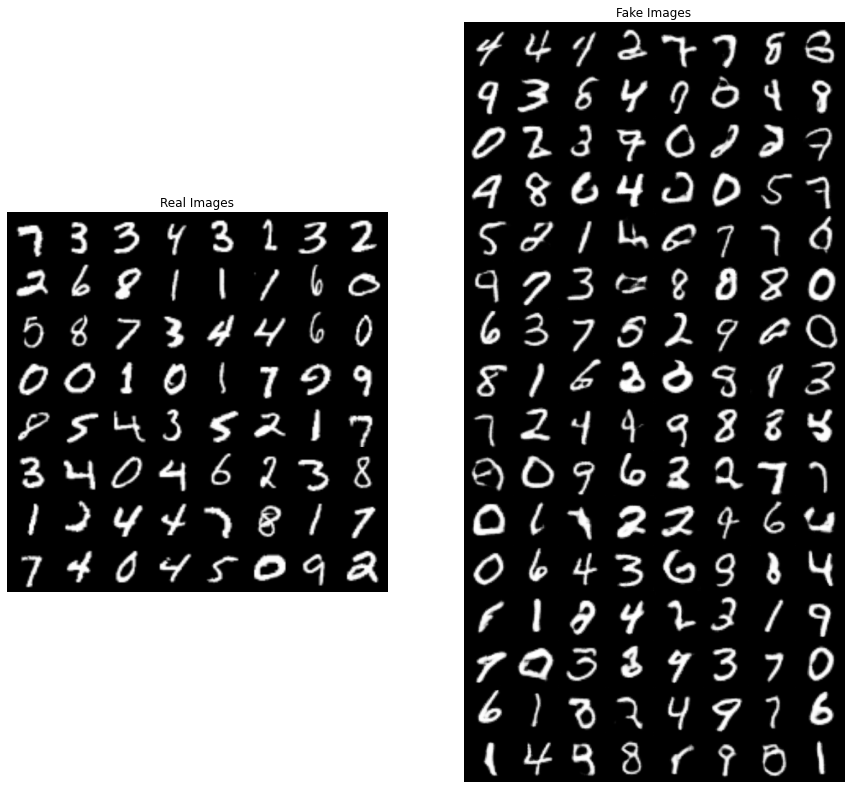

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Saving the GAN model parameters

In [20]:
with ema.average_parameters():
  torch.save(netG.state_dict(), "G_z_{0:}.ckpt".format(nz))
  torch.save(netD.state_dict(), "D_z_{0:}.ckpt".format(nz))

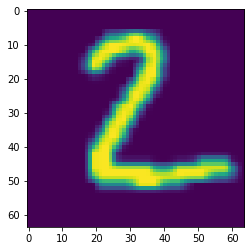

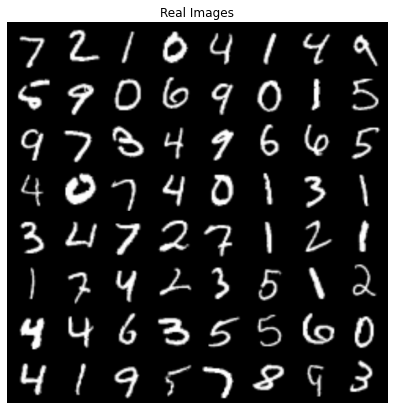

In [21]:
# Grab a batch of real images from the dataloader
test_batch = next(iter(test_dataloader))
X_test = test_batch[0][1].unsqueeze(0).cuda()
plt.imshow(X_test[0, 0].cpu())
plt.show()

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# Solving a physics-based ill-posed inverse problem with the pretrained GAN prior

## Selecting a sample from the test dataset as our ground truth

In [22]:
test_batch = next(iter(test_dataloader))
X_test = test_batch[0][0].cuda().unsqueeze(0)
plt.imshow(X_test[0, 0].cpu())
plt.show()

## Defining the Likelihood, Prior, and Posterior Probabilities

### Load the Generator Checkpoints

In [23]:
netG = Generator(ngpu=1).cuda()
netG.load_state_dict(torch.load("G_z_{0:}.ckpt".format(nz)))

for j, p in enumerate(netG.parameters()):
  p.requires_grad_(False)

def apply_eval(m):
  classname = m.__class__.__name__
  if classname.find('Batch') != -1:
    m = m.eval()

#netG = netG.apply(apply_eval)

### Define the Prior function which contains the Generator

In [24]:
class PriorFunction(nn.Module):
  def __init__(self, model, nz):
    super(PriorFunction, self).__init__()
    self.model = model
    self.dist = torch.distributions.MultivariateNormal(loc=torch.zeros(nz, device="cuda"), covariance_matrix=torch.eye(nz, device="cuda"))

  def forward(self, z):
    X = self.model(z)
    log_prob = self.dist.log_prob(z.flatten())
    return log_prob, X


In [25]:
prior_function = PriorFunction(netG, nz)

### Defining the Physics-based Operator

In [26]:
class RadonOperator(nn.Module):
  def __init__(self, batch_size: int = 1, n_angles: int = 1, image_size: int = 64, device: str = 'cuda'):
    super(RadonOperator, self).__init__()
    device = torch.device(device)

    # define measuring angles
    angles = np.linspace(0, np.pi, n_angles, endpoint=False)

    det_count = int(np.sqrt(2)*image_size + 0.5)
    self.radon = Radon(image_size, angles, clip_to_circle=False, det_count=det_count)

  def forward(self, X):
    return self.radon.forward(X)


### Define a Gaussian Likelihood Function w. constant variance per pixel 

In [27]:
def multivariate_normal_constant_variance_log_prob(X, mu, sigma=1):
  d = X.size(-2)*X.size(-1)
  return -0.5*(d*np.log(2*np.pi)+np.log(d)+2*np.log(sigma)+torch.nn.functional.mse_loss(X, mu)/sigma**2)


class LikelihoodFunction(nn.Module):
  def __init__(self, forward_operator, sigma: float=1.0):
    super(LikelihoodFunction, self).__init__()
    self.forward_operator = forward_operator
    self.sigma = sigma

  def forward(self, X, mu):
    d = self.forward_operator(X)
    log_prob = multivariate_normal_constant_variance_log_prob(d, mu, sigma=self.sigma)
    return log_prob, d

sigma = 10.0
forward_operator = RadonOperator(n_angles=32)
likelihood_function = LikelihoodFunction(forward_operator=forward_operator, sigma=sigma)

### Creating the observation data from an example from the test dataset

In [28]:
with torch.no_grad():
  obs = forward_operator(X_test)
  obs += sigma*torch.randn_like(obs)
  likelihood_log_prob, _ = likelihood_function(X_test, obs)

print(likelihood_log_prob.item())

plt.imshow(obs.cpu().numpy()[0, 0], aspect=8, cmap="gray")

-2682.724609375


### Callback to store gradients from a hook

In [29]:
grads = {}

def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

### Do one forward pass to compute the unscaled posterior probability

In [30]:
z = torch.randn(1, nz, 1, 1, requires_grad=True, device="cuda")
optimizer = torch.optim.SGD([z], lr=1e-2)

prior_log_prob, X = prior_function(z)
X.register_hook(save_grad('X'))

likelihood_log_prob, d = likelihood_function(X, obs)

posterior_log_prob = likelihood_log_prob+prior_log_prob
print(prior_log_prob, likelihood_log_prob, posterior_log_prob)

tensor(-150.4163, device='cuda:0', grad_fn=<SubBackward0>) tensor(-2682.9512, device='cuda:0', grad_fn=<MulBackward0>) tensor(-2833.3674, device='cuda:0', grad_fn=<AddBackward0>)


### Compute Backward Pass and Visualize Gradients and Changes to Parameter Field

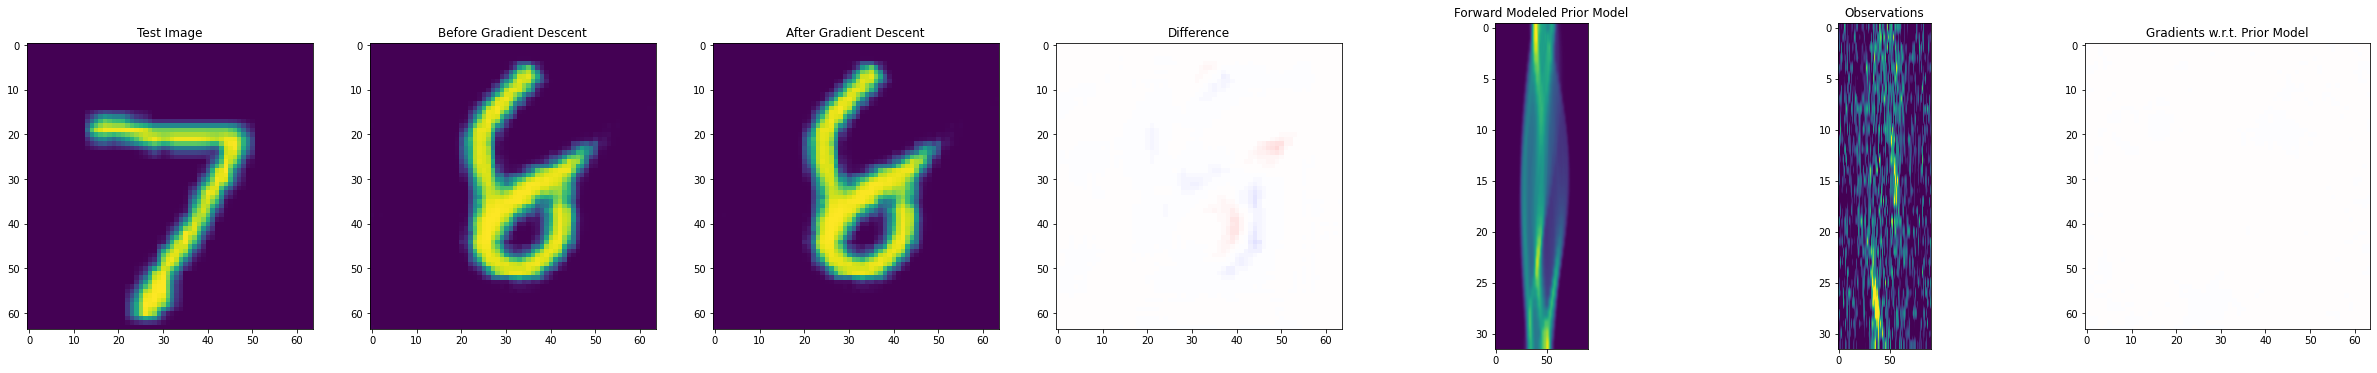

In [31]:
(-posterior_log_prob).backward()

X_before = X.detach().cpu().numpy()

optimizer.step()

with torch.no_grad():
  _, X_after = prior_function(z)

fig, ax = plt.subplots(1, 7, figsize=(42, 6))
ax[0].imshow(X_test[0, 0].cpu())
ax[1].imshow(X_before[0, 0])
ax[2].imshow(X_after[0, 0].detach().cpu())
ax[3].imshow(X_after[0, 0].detach().cpu()-X_before[0, 0], vmin=-0.01, vmax=0.01, cmap="seismic")
ax[4].imshow(d[0, 0].detach().cpu().numpy(), vmin=d.min(), vmax=d.max(), aspect=10)
ax[5].imshow(obs[0, 0].cpu().numpy(), vmin=d.min(), vmax=d.max(), aspect=10)
ax[6].imshow(grads['X'][0, 0].cpu().numpy(), vmin=-1, vmax=1, cmap="seismic")
for a, t in zip(ax, ["Test Image", "Before Gradient Descent", "After Gradient Descent", "Difference", "Forward Modeled Prior Model", "Observations", "Gradients w.r.t. Prior Model"]):
  a.set_title(t)
plt.show()

optimizer.zero_grad()

### Define the inversion step

In [32]:
def inversion_step(z, prior_function, likelihood_function, obs, register_grad: bool=False):
  grads = {}

  def save_grad(name):
      def hook(grad):
          grads[name] = grad
      return hook

  prior_log_prob, X = prior_function(z)

  if register_grad:
    X.register_hook(save_grad('X'))

  likelihood_log_prob, d = likelihood_function(X, obs)
  posterior_log_prob = likelihood_log_prob+prior_log_prob
  (-1*posterior_log_prob).backward()

  return prior_log_prob, likelihood_log_prob, posterior_log_prob, X, d, grads

## Run 10000 steps of gradient descent from an initial model and show outputs

-144.72311401367188 -2682.887451171875 -2827.610595703125 tensor(-0.0007, device='cuda:0') tensor(0.0016, device='cuda:0')


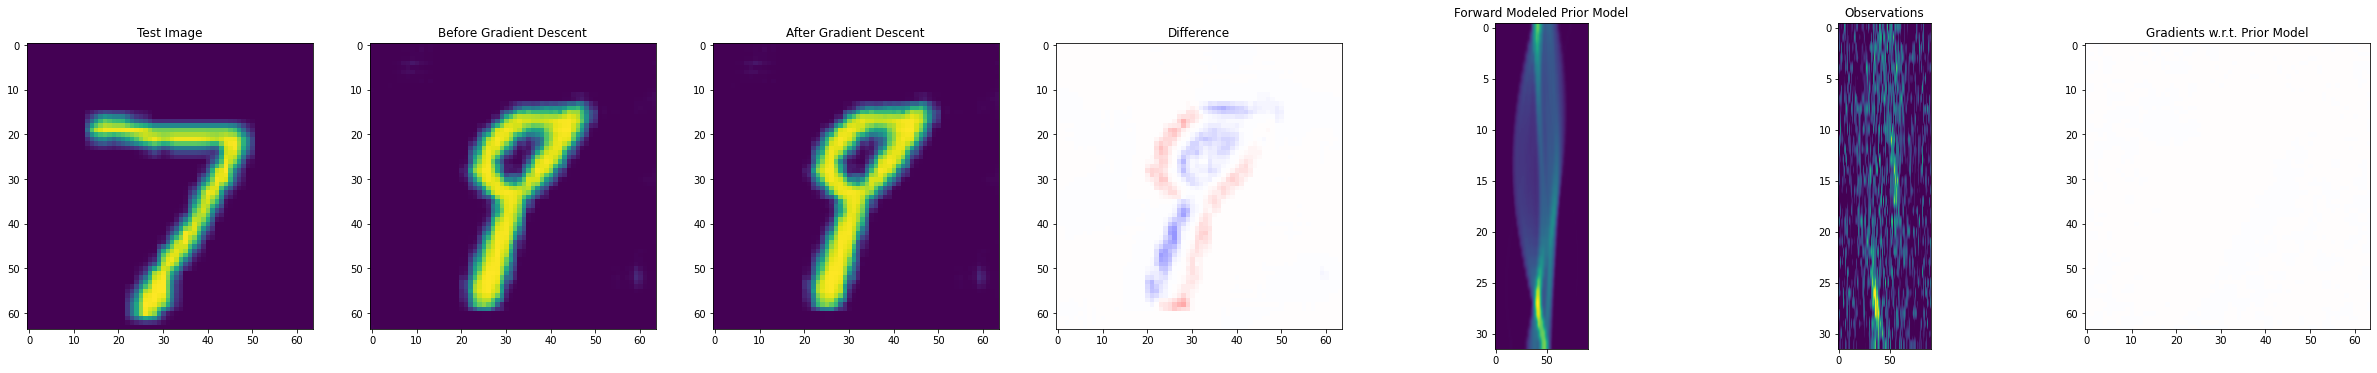

-98.97196960449219 -2682.863525390625 -2781.83544921875 tensor(-0.0007, device='cuda:0') tensor(0.0016, device='cuda:0')


-92.84225463867188 -2682.824462890625 -2775.666748046875 tensor(-0.0006, device='cuda:0') tensor(0.0015, device='cuda:0')


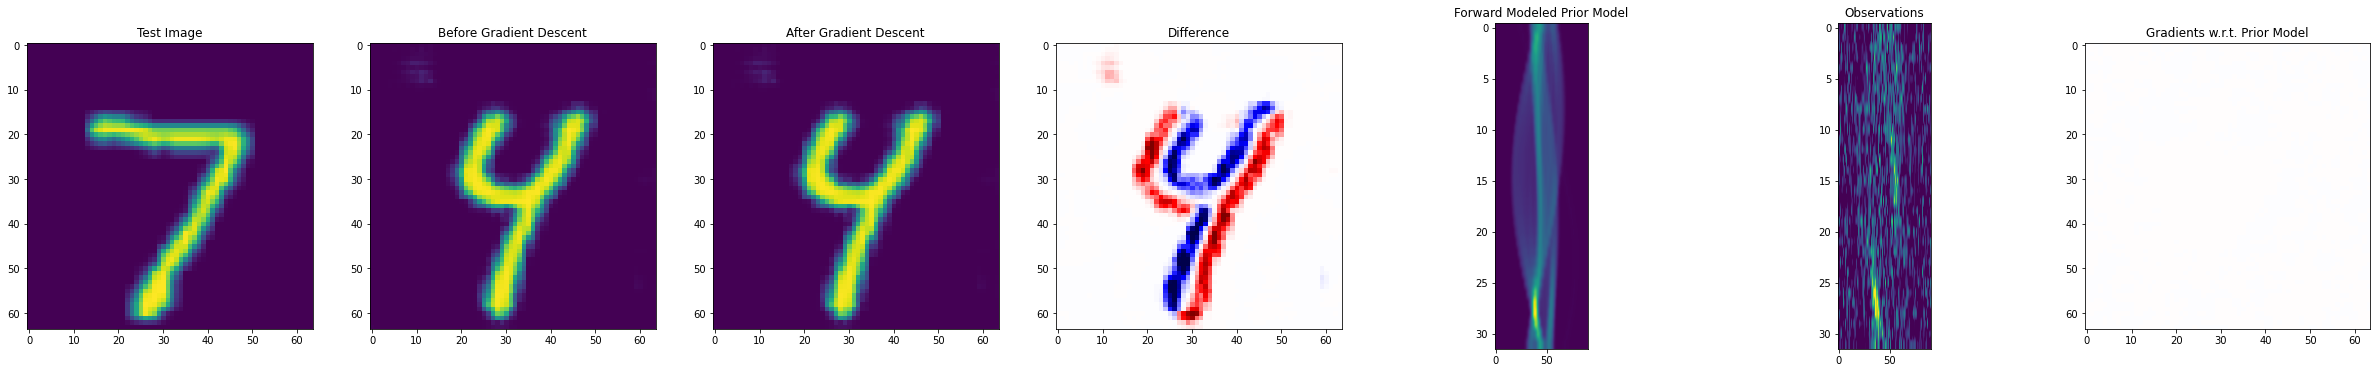

-92.02108764648438 -2682.78515625 -2774.80615234375 tensor(-0.0006, device='cuda:0') tensor(0.0013, device='cuda:0')


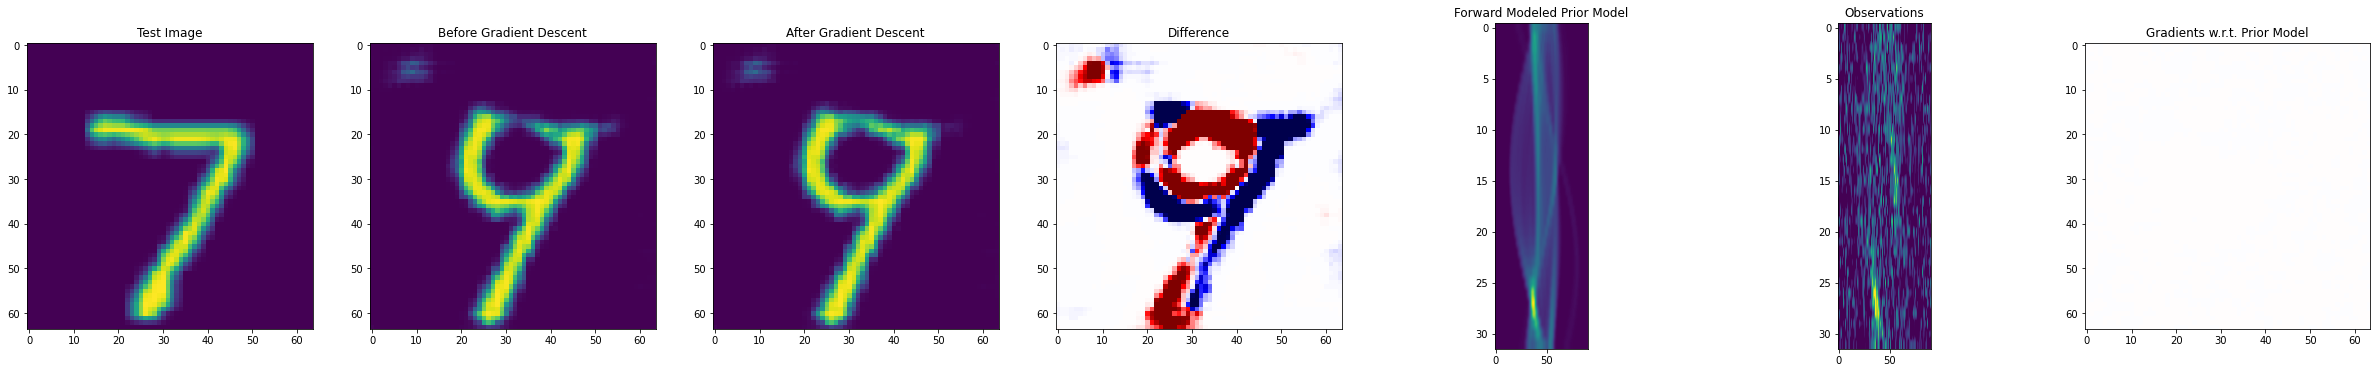

-91.91551208496094 -2682.733642578125 -2774.649169921875 tensor(-0.0006, device='cuda:0') tensor(0.0006, device='cuda:0')


-91.90203857421875 -2682.732421875 -2774.634521484375 tensor(-0.0006, device='cuda:0') tensor(0.0006, device='cuda:0')


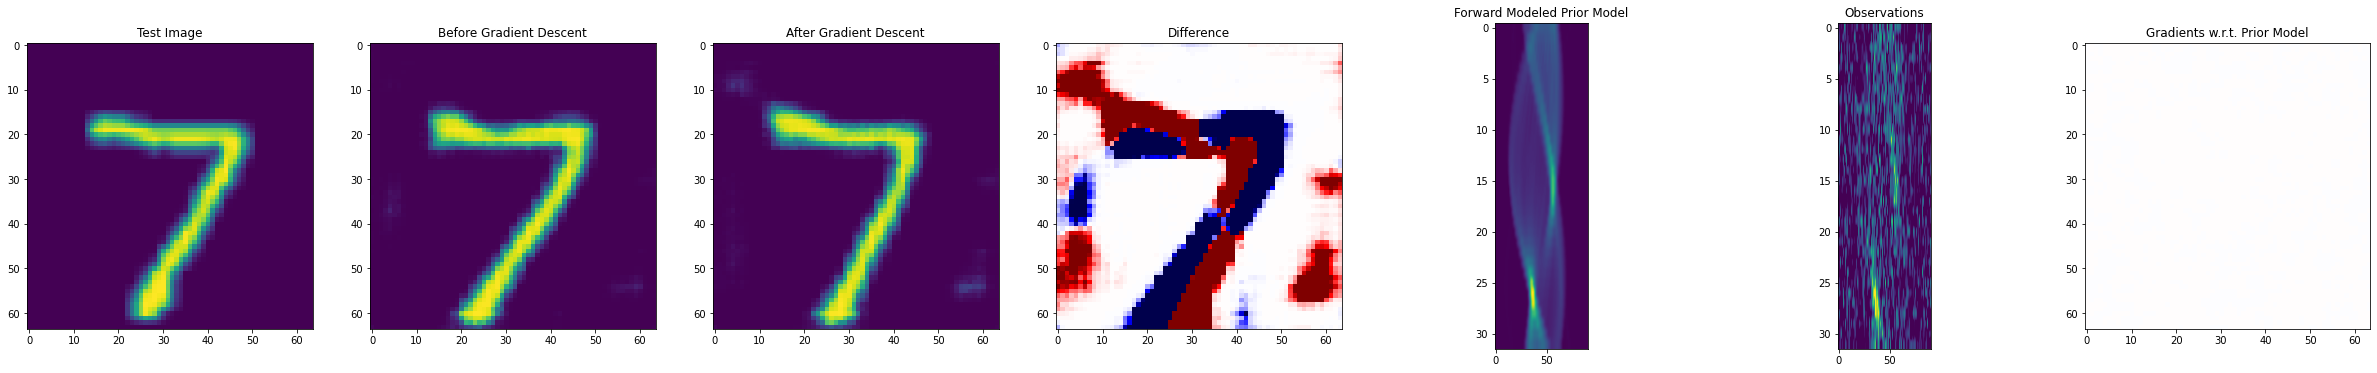

-91.90032958984375 -2682.732666015625 -2774.633056640625 tensor(-0.0006, device='cuda:0') tensor(0.0006, device='cuda:0')


-91.90010070800781 -2682.733154296875 -2774.63330078125 tensor(-0.0006, device='cuda:0') tensor(0.0006, device='cuda:0')


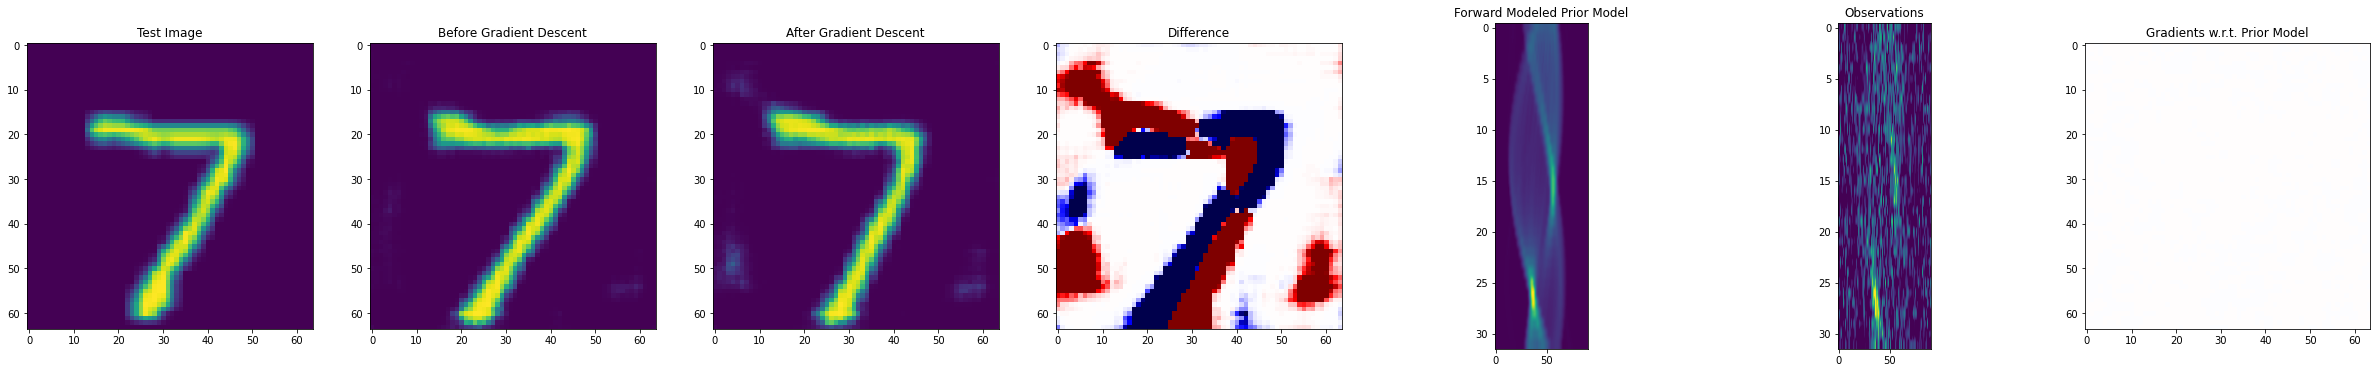

-91.89982604980469 -2682.7509765625 -2774.65087890625 tensor(-0.0007, device='cuda:0') tensor(0.0006, device='cuda:0')


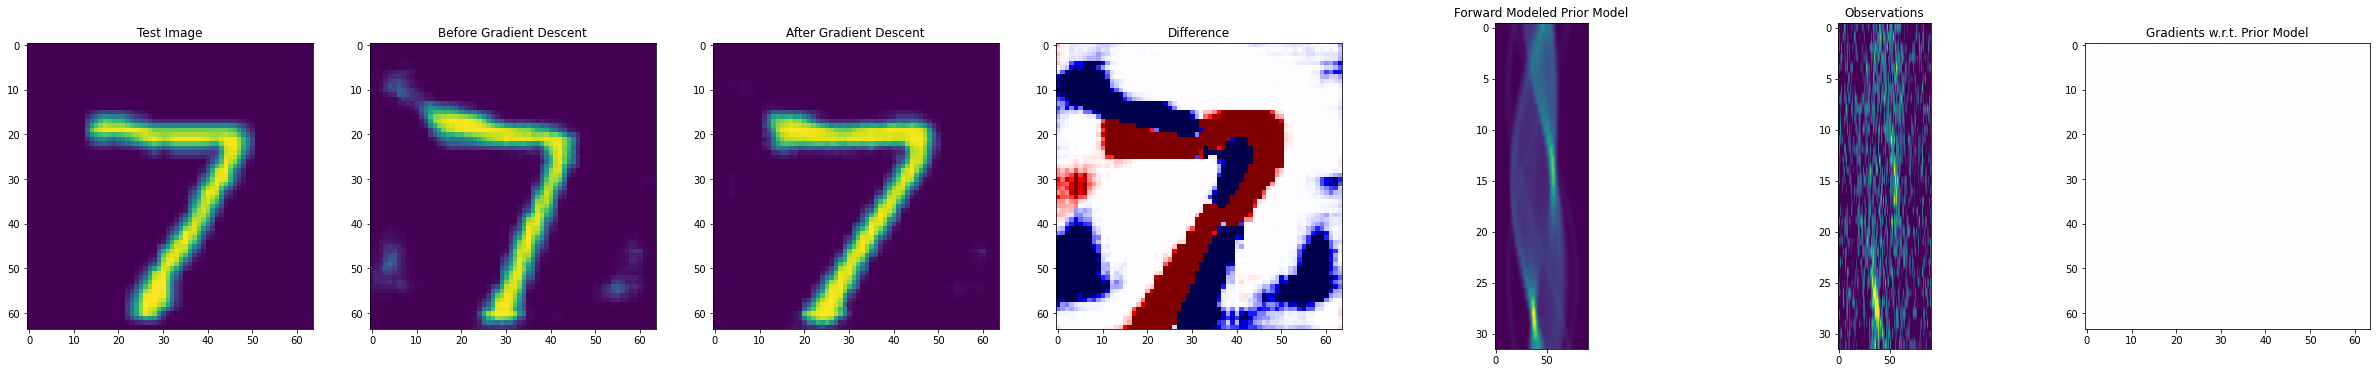

-91.89987182617188 -2682.732421875 -2774.63232421875 tensor(-0.0006, device='cuda:0') tensor(0.0006, device='cuda:0')


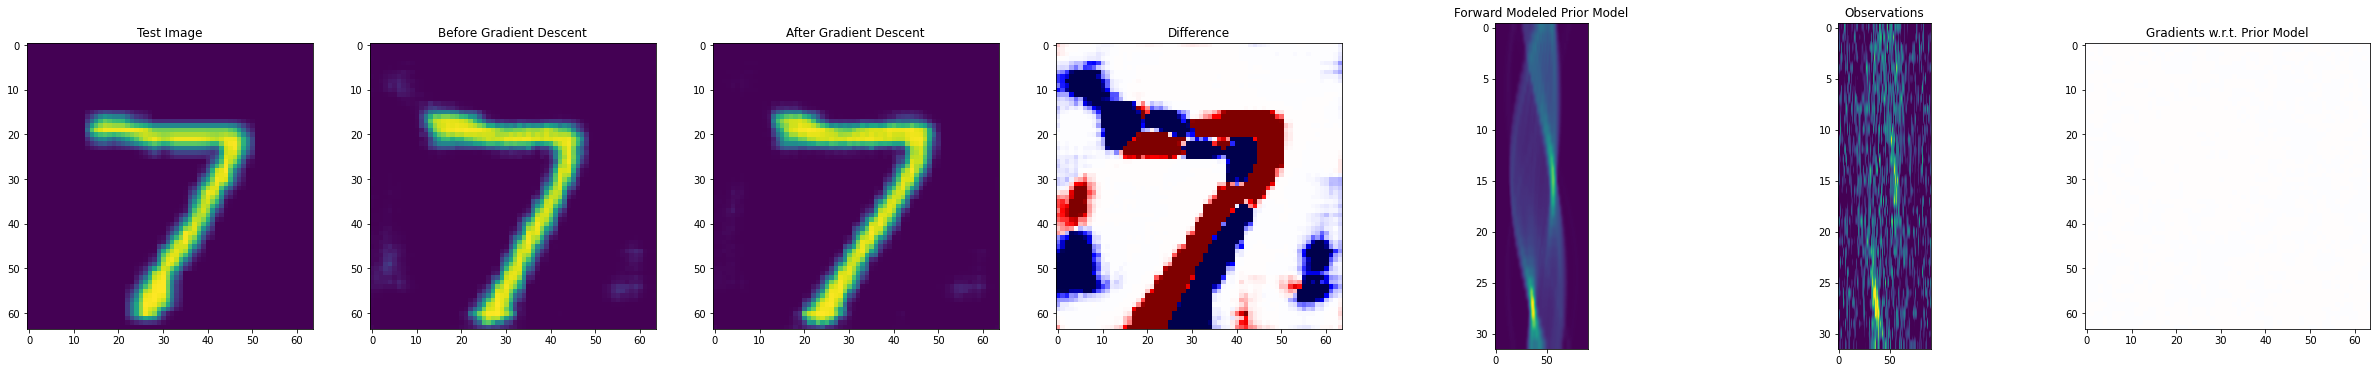

In [33]:
z = torch.randn(1, nz, 1, 1, requires_grad=True, device="cuda")
optimizer = torch.optim.SGD([z], lr=1e-2)

log_probs = []
for _ in range(1000):
  prior_log_prob, likelihood_log_prob, posterior_log_prob, X, d, grads = inversion_step(z, prior_function, likelihood_function, obs, register_grad=True)
  optimizer.step()
  optimizer.zero_grad()

  if _ % 100 == 0:
    print(prior_log_prob.item(), likelihood_log_prob.item(), posterior_log_prob.item(), grads['X'].min(), grads['X'].max())

    with torch.no_grad():
      _, X_after = prior_function(z)

    fig, ax = plt.subplots(1, 7, figsize=(42, 6))
    ax[0].imshow(X_test[0, 0].cpu())
    ax[1].imshow(X[0, 0].detach().cpu())
    ax[2].imshow(X_after[0, 0].detach().cpu())
    ax[3].imshow(X_after[0, 0].detach().cpu()-X[0, 0].detach().cpu(), vmin=-0.01, vmax=0.01, cmap="seismic")
    ax[4].imshow(d[0, 0].detach().cpu().numpy(), vmin=d.min(), vmax=d.max(), aspect=10)
    ax[5].imshow(obs[0, 0].cpu().numpy(), vmin=d.min(), vmax=d.max(), aspect=10)
    ax[6].imshow(grads['X'][0, 0].cpu().numpy(), vmin=-1, vmax=1, cmap="seismic")
    for a, t in zip(ax, ["Test Image", "Before Gradient Descent", "After Gradient Descent", "Difference", "Forward Modeled Prior Model", "Observations", "Gradients w.r.t. Prior Model"]):
      a.set_title(t)
    plt.show()

  log_probs.append([prior_log_prob.item(), likelihood_log_prob.item(), posterior_log_prob.item()])

### Plot the evolution of the log probabilities

In [34]:
log_probs = np.array(log_probs)

In [35]:
plt.plot(log_probs[:, 0], label="prior")
plt.plot(log_probs[:, 1], label="likelihood")
plt.plot(log_probs[:, 2], label="posterior")
plt.legend()
plt.xlim(0, 1000)
plt.yscale("linear")

Text(0, 0.5, 'Log Likelihood')

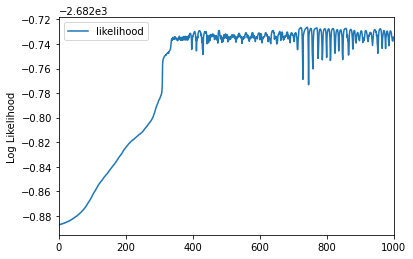

In [36]:
plt.plot(log_probs[:, 1], label="likelihood")
plt.legend()
plt.xlim(0, 1000)
plt.yscale("linear")
plt.ylabel("Log Likelihood")

### Invert 121 Samples that maximize the posterior probability

In [37]:
def sample_posterior(X_test, prior_function, likelihood_function, obs, n_gradient_steps=300):
  z = torch.randn(1, nz, 1, 1, requires_grad=True, device="cuda")
  optimizer = torch.optim.SGD([z], lr=1e-2)

  log_probs = []
  for _ in range(n_gradient_steps):
    prior_log_prob, likelihood_log_prob, posterior_log_prob, X, d, grads = inversion_step(z, prior_function, likelihood_function, obs, register_grad=False)
    optimizer.step()
    optimizer.zero_grad()

    log_probs.append([prior_log_prob.item(), likelihood_log_prob.item(), posterior_log_prob.item()])

  return X.detach().cpu().numpy(), np.array(log_probs)

inverted_X = []
all_log_probs = []
for _ in range(121):
  X, log_probs = sample_posterior(X_test, prior_function, likelihood_function, obs)

  inverted_X.append(X)
  all_log_probs.append(log_probs)

inverted_X = np.array(inverted_X)
all_log_probs = np.array(all_log_probs)

### Plot the mean and standard deviation per-pixel of samples from the prior

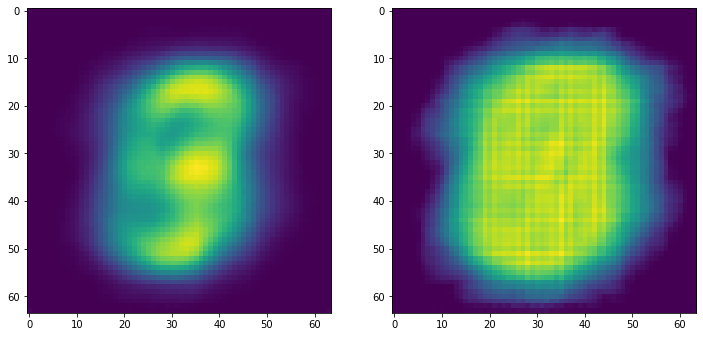

In [38]:
z_prior = torch.randn(500, nz, 1, 1, device="cuda")
X_prior = netG(z_prior).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.mean(X_prior, axis=0)[0])
ax[1].imshow(np.std(X_prior, axis=0)[0])
plt.show()

### Plot the mean and standard deviation per-pixel of samples from the MAP samples

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.mean(inverted_X, axis=0)[0, 0])
ax[1].imshow(np.std(inverted_X, axis=0)[0, 0])
plt.show()

### Show the evolution of the log probabilities for the samples

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
print(all_log_probs.shape)
for _, log_probs in enumerate(all_log_probs):
  ax.plot(log_probs[:, 0], color="black", label="Prior log Prob" if _ == 0 else None)
  ax.plot(log_probs[:, 1], color="red", label="Likelihood log Prob" if _ == 0 else None)
  ax.plot(log_probs[:, 2], color="blue", label="Posterior log Prob" if _ == 0 else None)
plt.legend()

(121, 300, 3)


### Show samples from the prior

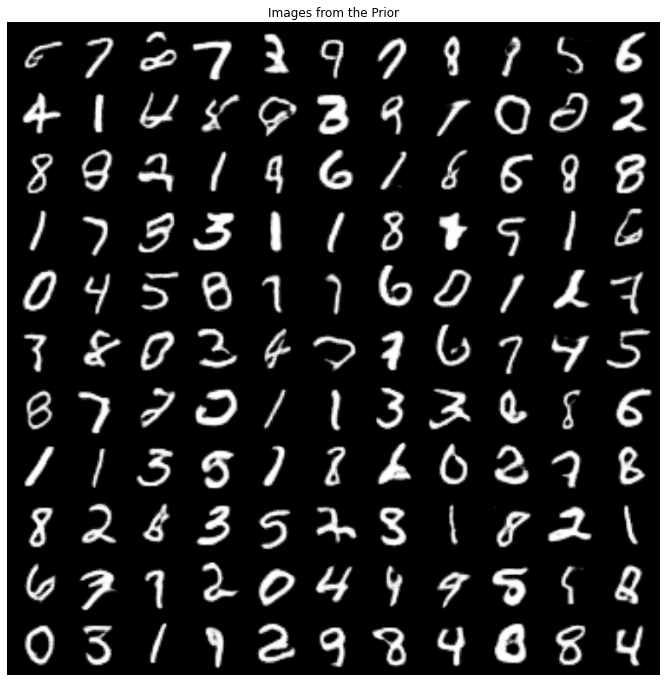

In [41]:
# Plot the real images
plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Images from the Prior")
prior_batch = torch.from_numpy(X_prior)[:121]
plt.imshow(np.transpose(vutils.make_grid(prior_batch, padding=5, normalize=False, nrow=11),(1,2,0)))


### Show samples from the MAP

In [42]:
# Plot the real images
plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("MAP Samples")
posterior_batch = torch.from_numpy(inverted_X)[:121, 0]
plt.imshow(np.transpose(vutils.make_grid(posterior_batch, padding=5, normalize=False, nrow=11),(1,2,0)))


## Perform Sampling from the MAP with different Likelihood Functions i.e. decreasing number of angles

In [43]:
def test_inversion_with_gan_prior(netG, X_test, n_angles=3, n_samples=121, n_gradient_steps=300, noise_sigma: float=0.0):
  prior_function = PriorFunction(netG, nz)
  
  forward_operator = RadonOperator(n_angles=n_angles)
  likelihood_function = LikelihoodFunction(forward_operator=forward_operator, sigma=noise_sigma)
  
  with torch.no_grad():
    obs = forward_operator(X_test)
    obs += noise_sigma*torch.randn_like(obs)

  inverted_X = []
  all_log_probs = []
  for _ in tqdm(range(121)):
    X, log_probs = sample_posterior(X_test, prior_function, likelihood_function, obs)

    inverted_X.append(X)
    all_log_probs.append(log_probs)

  inverted_X = np.array(inverted_X)
  all_log_probs = np.array(all_log_probs)

  z_prior = torch.randn(500, nz, 1, 1, device="cuda")
  X_prior = netG(z_prior).cpu().numpy()

  return X_prior, inverted_X, all_log_probs, obs

In [44]:
def plot_summary_graph(X_prior, inverted_X, all_log_probs):
  fig3 = plt.figure(constrained_layout=True, figsize=(12, 12))
  gs = fig3.add_gridspec(3, 4)
  f3_ax1 = fig3.add_subplot(gs[:1, :1])
  f3_ax1.set_title('Mean of the Prior')
  f3_ax1.imshow(np.mean(X_prior, axis=0)[0])

  f3_ax1 = fig3.add_subplot(gs[:1, 1:2])
  f3_ax1.set_title('Standard Deviation of the Prior')
  f3_ax1.imshow(np.std(X_prior, axis=0)[0])

  f3_ax4 = fig3.add_subplot(gs[:1, 2:3])
  f3_ax4.set_title('Mean of the MAP Samples')
  f3_ax4.imshow(np.mean(inverted_X, axis=0)[0, 0])

  f3_ax4 = fig3.add_subplot(gs[:1, 3:4])
  f3_ax4.set_title('Standard Deviation of the Map Samples')
  f3_ax4.imshow(np.std(inverted_X, axis=0)[0, 0])

  f3_ax3 = fig3.add_subplot(gs[1:2, :])
  f3_ax3.set_title('Log Probabilities')

  for _, log_probs in enumerate(all_log_probs):
    f3_ax3.plot(log_probs[:, 0], color="black", label="Prior log Prob" if _ == 0 else None)
    f3_ax3.plot(log_probs[:, 1], color="red", label="Likelihood log Prob" if _ == 0 else None)
    f3_ax3.plot(log_probs[:, 2], color="blue", label="Posterior log Prob" if _ == 0 else None)

  prior_batch = torch.from_numpy(X_prior)[:121]
  f3_ax4 = fig3.add_subplot(gs[2:, :2])
  f3_ax4.set_title('Samples from the Prior')
  f3_ax4.imshow(np.transpose(vutils.make_grid(prior_batch, padding=5, normalize=False, nrow=11),(1,2,0)))

  posterior_batch = torch.from_numpy(inverted_X)[:121, 0]
  f3_ax2 = fig3.add_subplot(gs[2:, 2:4])
  f3_ax2.set_title('Samples from the MAP')
  f3_ax2.imshow(np.transpose(vutils.make_grid(posterior_batch, padding=5, normalize=False, nrow=11),(1,2,0)))

### Detector with 32 Angles and no noise

100%|██████████| 121/121 [01:54<00:00,  1.05it/s]


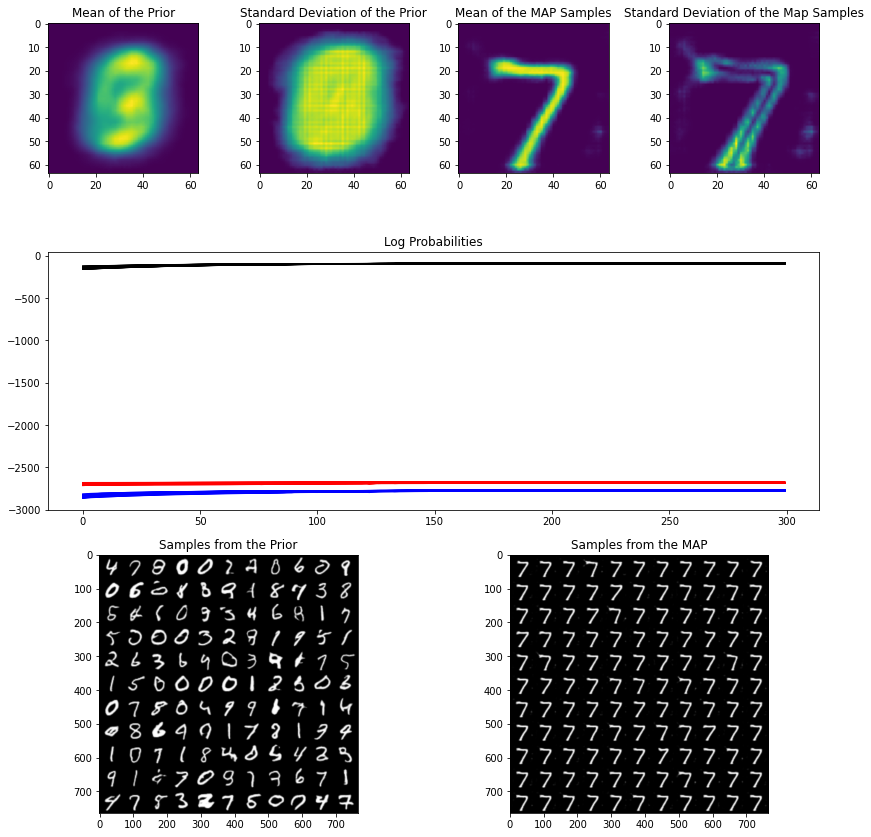

In [45]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=32, n_samples=121, n_gradient_steps=300, noise_sigma=1.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()

### Detector with 3 Angles and no noise

100%|██████████| 121/121 [01:54<00:00,  1.06it/s]


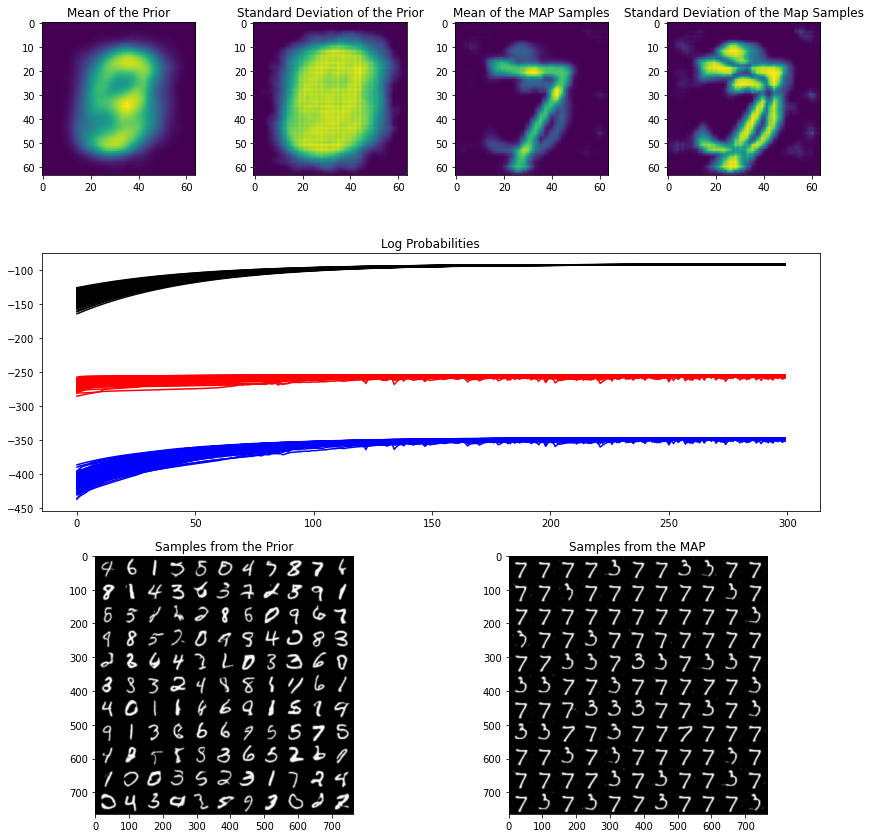

In [46]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=3, n_samples=121, n_gradient_steps=300, noise_sigma=1.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()

### Detector with 2 Angles and no noise

100%|██████████| 121/121 [01:54<00:00,  1.05it/s]


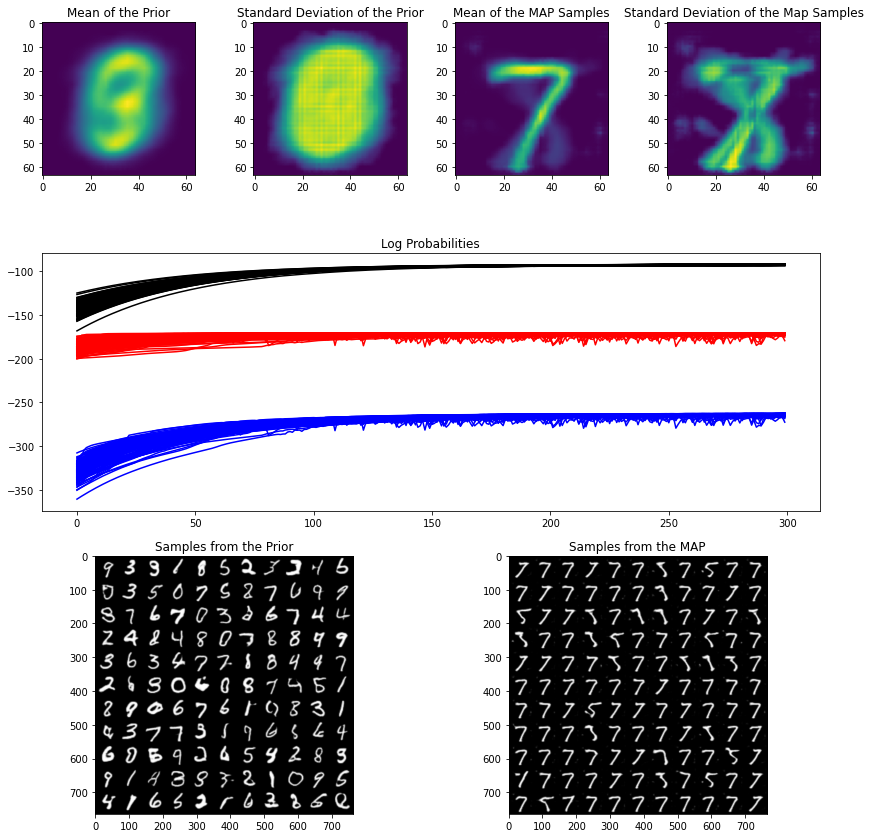

In [47]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=2, n_samples=121, n_gradient_steps=300, noise_sigma=1.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()

### Detector with 1 Angles and no noise

100%|██████████| 121/121 [01:54<00:00,  1.06it/s]


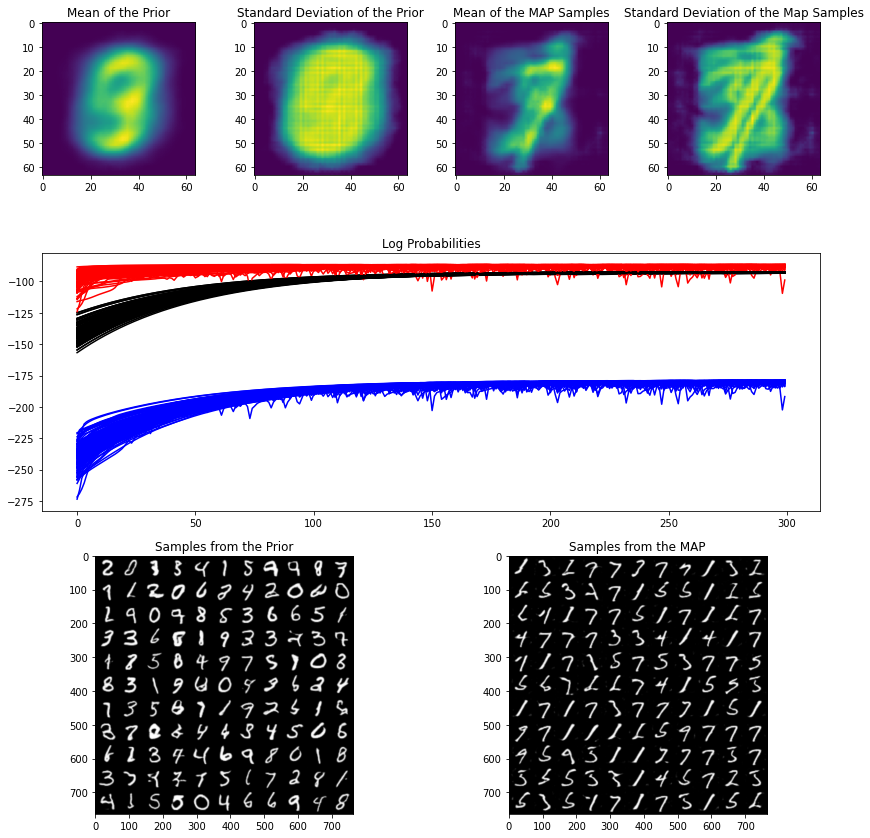

In [48]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=1, n_samples=121, n_gradient_steps=300, noise_sigma=1.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()

### Detector with 32 Angles and alot noise

100%|██████████| 121/121 [01:54<00:00,  1.06it/s]


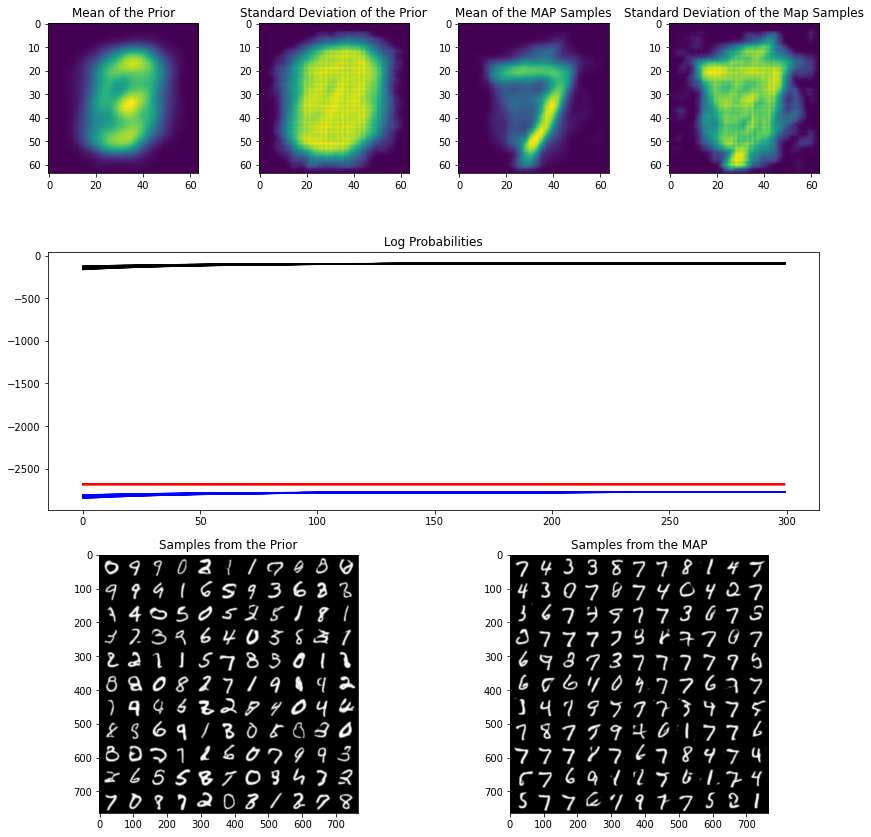

In [49]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=32, n_samples=121, n_gradient_steps=300, noise_sigma=25.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()

### Detector with 3 Angles and alot noise

100%|██████████| 121/121 [01:54<00:00,  1.06it/s]


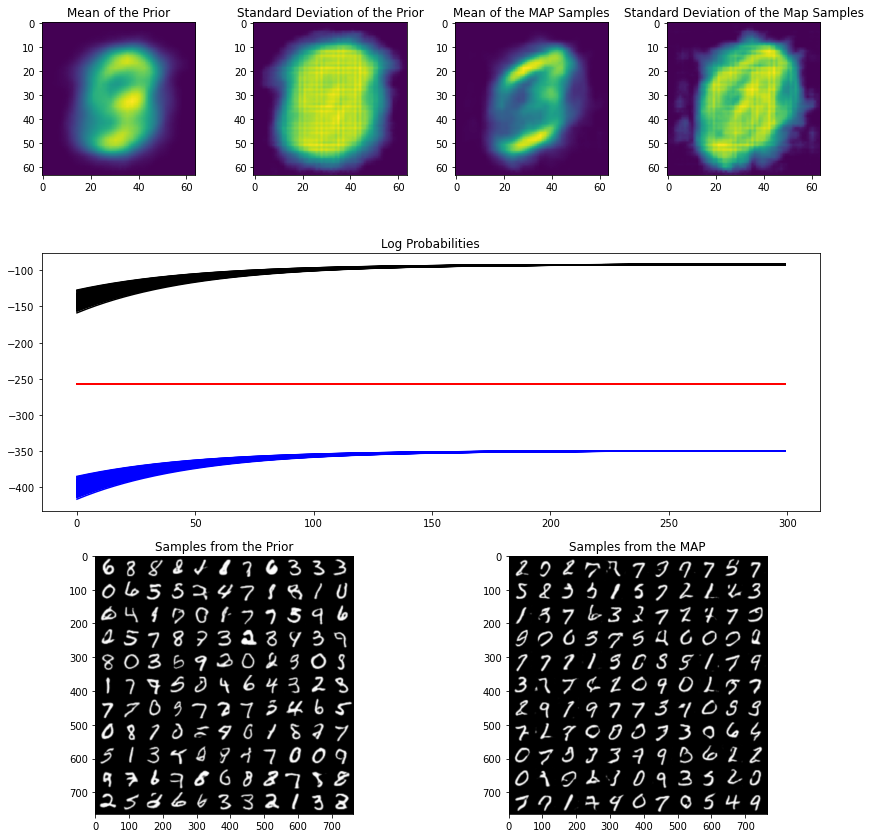

In [50]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=3, n_samples=121, n_gradient_steps=300, noise_sigma=25.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()

### Detector with 2 Angles and alot noise

In [51]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=2, n_samples=121, n_gradient_steps=300, noise_sigma=25.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()

100%|██████████| 121/121 [01:54<00:00,  1.06it/s]


### Detector with 1 Angles and alot noise

100%|██████████| 121/121 [01:54<00:00,  1.06it/s]


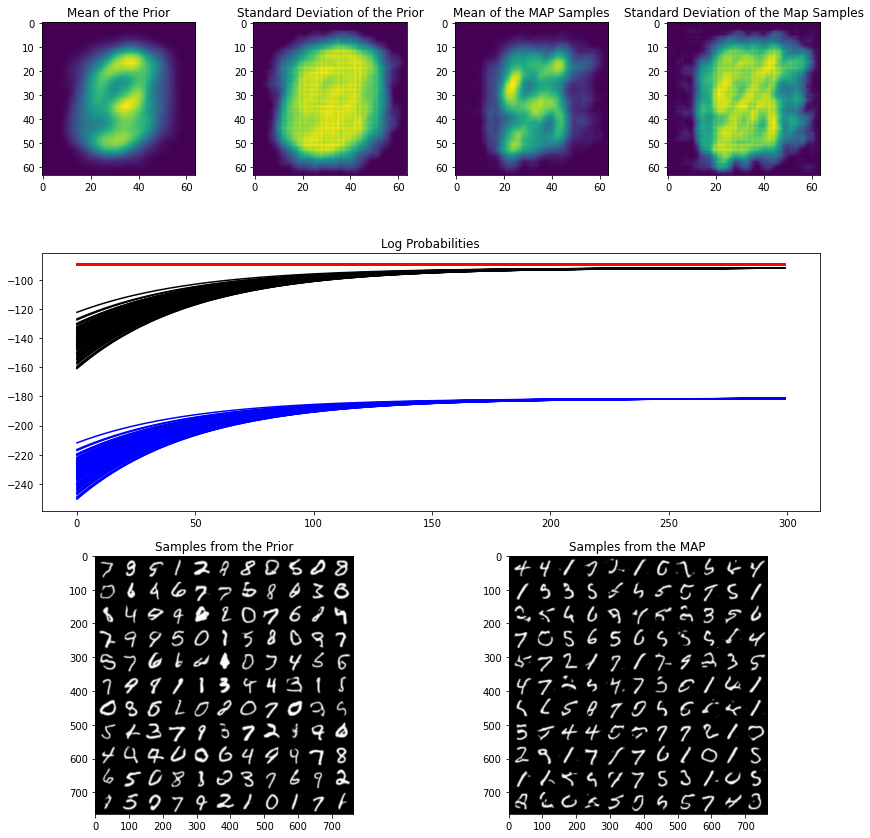

In [52]:
X_prior, inverted_X, all_log_probs, _ = test_inversion_with_gan_prior(netG, X_test, n_angles=1, n_samples=121, n_gradient_steps=300, noise_sigma=25.0)
plot_summary_graph(X_prior, inverted_X, all_log_probs)
plt.show()